In [79]:
import pandas as pd
dataset = pd.read_csv("../../Data/cleaned_v1.csv")
dataset

,Unnamed: 0,Content,Label,Content_cleaned,Length_content_cleaned
0,0,Sao Việt ngày 29/3: NSƯT Chí Trung cùng bạn gá...,entertainment,việt nsưt chí_trung gái đi du_lịch mỹ ...,21
1,1,Người tiêu dùng trẻ ngày càng có xu hướng chi ...,business,tiêu_dùng trẻ xu_hướng chi_tiêu thông_minh tận...,311
2,2,Trong khuôn viên rất rộng ở khu liên hợp thể t...,sport,khuôn_viên rộng khu liên_hợp thể_thao techo mo...,253
3,3,Một trong những triệu chứng điển hình của tiểu...,health,triệu_chứng điển_hình tiểu tần_suất đi_tiểu nư...,287
4,4,"Từ ngày 27/2-2/3, Hiệp hội golf Việt Nam tổ ch...",sport,hiệp_hội golf việt_nam tổ_chức vòng_lo...,105
...,...,...,...,...,...
24409,2920,"Ở nội dung đôi nam nữ, Trần Ngọc Thúy Vi và Lê...",sport,nội_dung đôi nam_nữ trần_ngọc thúy_vi lê_hoà...,149
24410,2924,Nguồn: Next Sports Thiên Bình,sport,next sports thiên_bình,3
24411,2925,Nhận định trận đấu giữa Arsenal vs Brighton Tr...,sport,nhận_định trận_đấu arsenal vs brighton khuôn_k...,156
24412,2926,Dù giành chiến thắng trước Myanmar ở vòng bảng...,sport,giành chiến_thắng myanmar vòng bảng hlv mai_đứ...,138


In [80]:
from gensim.models import Word2Vec
w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2v_300_5window_cleaned_24krow_skipgram.model")

In [81]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

import numpy as np

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(dataset["Label"])
# token_label_seq = np.array(label_tokenizer.texts_to_sequences(dataset['Label']))
tokenizer.fit_on_texts(dataset['Content_cleaned'])
sequences = tokenizer.texts_to_sequences(dataset['Content_cleaned'])

maxlen = 200
X = sequence.pad_sequences(sequences, maxlen=maxlen)
print('X:\n', X[:10])


X:
 [[    0     0     0 ...   319  1205   738]
 [  384   155    39 ...   394   707   610]
 [ 4494  3563  8803 ...  2820  2841   321]
 ...
 [    0     0     0 ...  1745  2328  1294]
 [  322    49   191 ...  4629 59517   532]
 [  323   721   473 ...    17  2727  5551]]


In [82]:
y = pd.get_dummies(dataset['Label'])
y

,business,education,entertainment,health,politics,sport
0,0,0,1,0,0,0
1,1,0,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
24409,0,0,0,0,0,1
24410,0,0,0,0,0,1
24411,0,0,0,0,0,1
24412,0,0,0,0,0,1


In [83]:
import numpy as np

embedding_dim = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.wv.key_to_index:
            embedding_matrix[i] = w2v.wv[word]

num_words: 109106


In [84]:
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, SimpleRNN, Dropout

# model = Sequential()
# model.add(Embedding(num_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
# model.add(Bidirectional(LSTM(units=256)))
# model.add(Dropout(0.2))
# model.add(Dense(units=128, activation='relu'))
# model.add(Dense(units=16, activation='relu'))
# model.add(Dense(6, activation='softmax'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, SimpleRNN, Dropout

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(SimpleRNN(units=256))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 300)          32731800  
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 256)               142592    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 32)                4128      
                                                                 
 dense_24 (Dense)            (None, 6)                 198       
                                                                 
Total params: 32,911,614
Trainable params: 179,814
Non-trainable params: 32,731,800
_________________________________________________________________


In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y , test_size= 0.3, random_state= 42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((17089, 200), (17089, 6), (7325, 200), (7325, 6))

In [91]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = "val_loss", patience= 4)

In [92]:
model.fit(X_train, Y_train, validation_split=0.1, epochs= 100, callbacks=[callback])

Epoch 1/100
203/481 [===========>..................] - ETA: 22s - loss: 0.3254 - accuracy: 0.5674

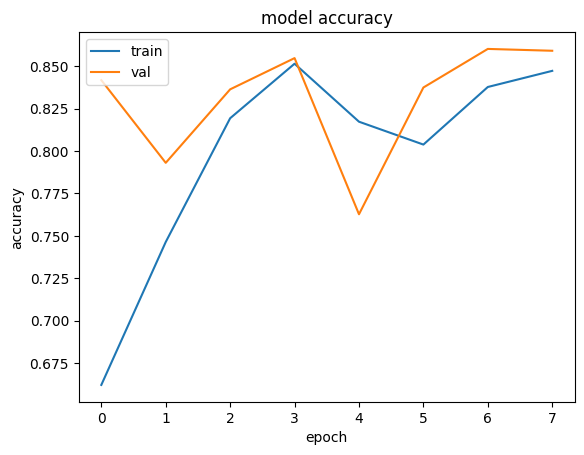

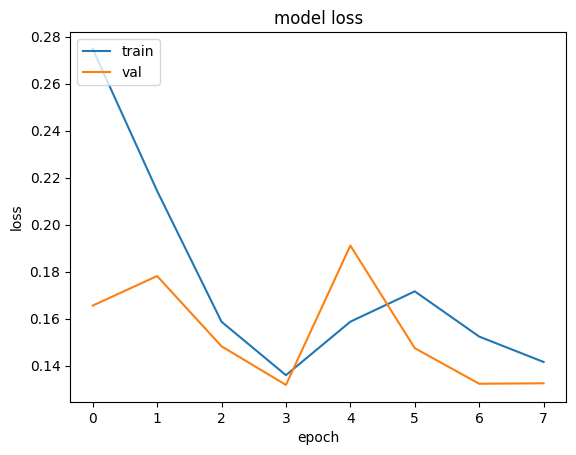

In [77]:
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [78]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

124/124 [==============================] - 4s 28ms/step - loss: 0.1389 - accuracy: 0.8399
Test Loss: 0.13886553049087524
Test Accuracy: 0.8399494290351868
